# 입차 시 사용 될 코드

# library

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import re
import easyocr
import pymysql

import utils_test

c:\Python3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Webcam

In [3]:
utils_test.webcam(0,'intro_image')

# Yolo & OCR

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


클래스 번호:  0 
클래스: norm 
norm일 확률:  0.9937870502471924


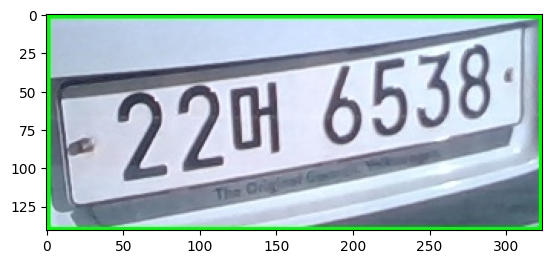

In [4]:

img_path = './image/intro_image/img.png'

img = cv2.imread(img_path)

with open('obj.names', 'r') as f:
    classes = f.read().splitlines()

#cfg 파일에 batch, subdivisions 는 둘 다 1이어야함

net = cv2.dnn.readNetFromDarknet('yolov4-tiny-custom.cfg', 'yolov4-tiny-custom_best.weights')

model = cv2.dnn_DetectionModel(net)
model.setInputParams(scale=1 / 255, size=(416, 416), swapRB=True)

try : 
    classIds, scores, boxes = model.detect(img, confThreshold=0.6, nmsThreshold=0.4)

    clss = classIds.tolist()
    score = scores.tolist()

    # 주차딱지 변수 값 지정
    # Object Detection 했을 때 주차딱지가 Detection 안 되면 class_num_y와 class_name_yellow 는 'x'값을 가짐
    # 주차딱지가 Detection 되면 class_num_y는 '3', class_name_yellow 는 '주차딱지' 값을 가짐 (아래에 있는 if 문)

    class_num_y = '0'
    class_name_yellow = 'x'

    reader = easyocr.Reader(['ko'])

    # # 검출된 bbox 중, 클래스가 0(norm), 1(elec), 3(yellow) 이면 이미지 출력

    for i in range(len(clss)):
        box = boxes[i].tolist()
        w = box[0]
        h = box[1]
        x = box[2]
        y = box[3]
        bbox = img[h:y+h, w:x+w]


        if clss[i] == 0:
            print('클래스 번호: ', clss[i], '\n클래스: norm', '\nnorm일 확률: ', score[i])

            # 22.11.05  옮김 ㅎㅅㅇ
            class_num = str(clss[i])
            class_name = '일반'

            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            cv2.imwrite('./image/intro_image/norm.jpg', bbox) #저장
            norm = Image.open('./image/intro_image/norm.jpg')

            if bbox is None:
                print('Image load failed!')
                bbox.exit()
            
            norm_norm = Image.open("./image/intro_image/norm.jpg")
            plt.imshow(norm_norm)
            result = reader.readtext(norm_norm)
            
            if len(result[0][1]) <= 2:
                src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
                dst1 = cv2.inRange(bbox, (0, 0, 0), (80, 80, 80))
                cv2.imwrite('./image/intro_image/norm_black.jpg', dst1)
                norm_black = Image.open('./image/intro_image/norm_black.jpg')
                result = reader.readtext(norm_black)
            
                if len(result) ==0:
                    norm_re = norm.resize((int(norm.width*2), int(norm.height)))         
                    norm_re.save('./image/intro_image/norm_re.jpg')
                    norm_re = cv2.imread('./image/intro_image/norm_re.jpg')
                    src_hsv = cv2.cvtColor(norm_re, cv2.COLOR_BGR2HSV)
                    dst1 = cv2.inRange(norm_re, (0, 0, 0), (120, 120, 120))
                    cv2.imwrite('./image/intro_image/norm_re_black.jpg', dst1)
                    norm_re_black = Image.open('./image/intro_image/norm_re_black.jpg')
                    result = reader.readtext(norm_re_black)
                    plt.imshow(norm_re_black)

        elif clss[i] == 1:
            print('클래스 번호: ', clss[i], '\n클래스: elec', '\nelec일 확률: ', score[i])

            class_num = str(clss[i])
            class_name = '전기'

            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            cv2.imwrite('./image/intro_image/elec.jpg', bbox)

            elec = Image.open('./image/intro_image/elec.jpg')

            if bbox is None:
                print('Image load failed!')
                bbox.exit()
                
            elec_norm = Image.open("./image/intro_image/elec.jpg")
            plt.imshow(elec_norm)
            result = reader.readtext(elec_norm)
            
            if len(result[0][1]) <= 2:
                src_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
                dst1 = cv2.inRange(bbox, (0, 0, 0), (70, 80, 80))
                cv2.imwrite('./image/intro_image/elec_black.jpg', dst1)
                elec_black = Image.open('./image/intro_image/elec_black.jpg')
                result = reader.readtext(elec_black)
                
                if len(result) ==0:
                    elec_re = elec.resize((int(elec.width*2), int(elec.height)))         
                    elec_re.save('./image/intro_image/elec_re.jpg')
                    elec_re = cv2.imread('./image/intro_image/elec_re.jpg')
                    src_hsv = cv2.cvtColor(elec_re, cv2.COLOR_BGR2HSV)
                    dst1 = cv2.inRange(elec_re, (0, 0, 0), (130, 130, 130))
                    cv2.imwrite('./image/intro_image/elec_re_black.jpg', dst1)
                    elec_re_black = Image.open('./image/intro_image/elec_re_black.jpg')
                    result = reader.readtext(elec_re_black)
                    plt.imshow(elec_re_black)

        if clss[i] == 3:
            print('클래스 번호: ', clss[i], '\n클래스: yellow', '\nyellow일 확률: ', score[i])
            cv2.rectangle(bbox, (0,0), (x, y), (0,255,0), 3)
            class_num_y = '1'
            class_name_yellow = '주차딱지'
    # -- 이미지 에러가 나면 출력할 구문
except :
  print('====IMG_ERR====')

In [8]:
result

[([[165.85884908971124, 25.291856722960475],
   [300.48692093244955, 4.318135327014677],
   [308.14115091028873, 76.70814327703953],
   [172.51307906755045, 96.68186467298533]],
  '6538',
  0.9886099696159363),
 ([[36.2682698535109, 39.16817625290558],
   [162.28728818094328, 28.718387465187895],
   [164.7317301464891, 107.83182374709442],
   [38.712711819056715, 118.2816125348121]],
  '22머',
  0.9692265391349792)]

# 문자 추출

In [6]:
first_num, second_num = utils_test.result_plate(result)

In [7]:
print('차량번호 앞자리: ', first_num,
      '\n차량번호 뒷자리: ', second_num)

차량번호 앞자리:  22머 
차량번호 뒷자리:  6538


# 입차 시 시간

In [9]:
in_time = utils_test.car_time()
in_time

'14:38'

# total_info 에 저장
## total_info : 변수 생성된 정보 각 컬럼에 저장하는 테이블

In [11]:
conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'car_manage', charset='utf8')
 
cur = conn.cursor()

#데이터베이스는 있는데 테이블은 아직 안 만들었을 때, 밑에 줄 주석 풀고 한 번 실행하면 테이블 생성됨
#cur.execute("create table total_info (last_number varchar(4), car_elec varchar(1), person_type varchar(1), first_number varchar(4), intro_time varchar(20))")


# -- pk(last_number) 중복 insert시 예외처리

try: 
    cur.execute(f"insert into total_info values(\"{second_num}\", \"{class_num}\", \"{class_num_y}\", \"{first_num}\", \"{in_time}\")")

# -- 예외 발생 시 출력 구문
except :
    print('duplicate number')

# -- 예외 없을 때 commit
else : 
    conn.commit()

# intro_info 에 저장
## intro_info : 변수 생성된 정보들을 str 타입으로 된 한 줄로 저장. 아두이노에서 LCD에 띄울 때 사용할 것

In [12]:
###### 입차 시 이용하는 한줄로 된 str
first_num = '{0:0>4}'.format(first_num)

conn = pymysql.connect(host='127.0.0.1', user='root', password='multi123', db = 'car_manage', charset='utf8')

cur = conn.cursor()

#아랫줄은 제일 처음에 table 생성 시에만 사용함
#cur.execute("create table intro_info (intro_str varchar(30))")

cur.execute(f"insert into intro_info values(\"{second_num}{first_num}{class_num_y}{class_num}{in_time}\")")

conn.commit()